# Towards Quantum Auto Encoders
## Importing necessary libraries

In [124]:
# Train on the data
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb # model
import seaborn
from tqdm import tqdm # to display progress bar


# misc
from keras.callbacks import Callback
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import random as rn
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix

# visualisations
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# read & manipulate data
import pandas as pd 
import numpy as np

# manual parameters
RANDOM_SEED = 42 # the answer to the life, universe and everything
SAMPLE_SIZE = 10000
SPLIT_RATIO = 0.2
BATCH_SIZE = 1024
EPOCHS = 150
NN_EPOCHS = 50
NN_BATCH_SIZE = 20
THRESOLD_FIXED = 4


# setting the random seeds for reproducibilty
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

## Reading the data

In [97]:
#fin = "../input/creditcardfraud/creditcard.csv"
fin = "creditcard.csv"
data = pd.read_csv(fin)
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [98]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


## MAIN CHALLENGE
the dataset is **highly imbalanced** (99.83 : 0.17)

Handle unbalanced dataset
The data set is higly unbalanced, it contains only 0.17% fraudulent data. Training model on unbalacend data raise the risk of overfitting model and it will have poor classifcation score on the minority class. For instance a model that returns always 0 will have an accuracy of 99.8% but all the class 1 will be all wrong thus the recall will be null. In order to train the model we need to balanced the dataset and to use confusion matrix to evaluate the model. The confusion matrix will allow us to understand how is each class is classified and thus understand which model classify the best fraudalent class.

In the literatutre there exists several to balanced dataset, the most common one are :

under sampling majority class
over sampling minority (SMOTE)
The SMOTE approach has been used in the article Credit Card Fraud DEtection Using Autoencoder https://arxiv.org/ftp/arxiv/papers/1908/1908.11553.pdf) The undersampled approached has been used in numerous kaggle competition in other QML. The interest of this apporach it will us to reduce the size of the data set and thus use the same data set for classical AE and Quantum AE. An potential approach could :

1) test AE on oversample

2) test AE on undersample

3) use same undersample and test QAE

it will us to compare classical vs quantum on reduced data set and allow to compare classical on full data set and understand if QAE can obtain similar result with a

## Under Sampling the dataset

In [99]:
# subsampling to get a more balaced dataset
non_fraud = data[data['Class'] == 0].sample(SAMPLE_SIZE)
# non_fraud = data[data['Class'] == 0]

fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [100]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(Y), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,10000,95.31
1,1,492,4.69


## Visualize Fraud and NonFraud Transactions 
Every dot in the following represents a transaction. Non Fraud transactions are represented as Green while Fraud transactions are represented as Red. The two axis are the components extracted by tsne. 

In [101]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original_"+str(SAMPLE_SIZE)+".png")

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TypeError: must be real number, not str

TypeError: must be real number, not str

<Figure size 864x576 with 1 Axes>

From the above graph we can observe that there are many non_fraud transactions which are very close to fraud transactions, thus are difficult to accurately classify from a model. 

In [132]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='elu', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='elu')(encoded)
encoded = Dense(25, activation='elu')(encoded)

## decoding part
decoded = Dense(25, activation='elu')(encoded)
decoded = Dense(50, activation='elu')(decoded)
decoded = Dense(100, activation='elu')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='elu')(decoded)

In [133]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

## Retrospectively, scaling seems to provide better results

In [134]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
xs_non_fraud, xs_fraud = x_scale[y == 0], x_scale[y == 1]  # xs - scaled x

In [135]:
#using train / test split 
df_norm = df.copy()
# Reshape your data either using array.reshape(-1, 1) if your data has a single feature
# or array.reshape(1, -1) if it contains a single sample.
df_norm['Time'] = StandardScaler().fit_transform(df_norm['Time'].values.reshape(-1, 1))
df_norm['Amount'] = StandardScaler().fit_transform(df_norm['Amount'].values.reshape(-1, 1))

train_x, test_x = train_test_split(df_norm, test_size=0.3, random_state=314)
train_x = train_x[train_x.Class == 0]       # where normal transactions
train_x = train_x.drop(['Class'], axis=1)   # drop the class column


test_y = test_x['Class']                    # save the class column for the test set
test_x = test_x.drop(['Class'], axis=1)     # drop the class column

train_x = train_x.values                    # transform to ndarray
test_x = test_x.values                      # transform to ndarray

In [136]:
historyv2 = autoencoder.fit(train_x, train_x, 
                batch_size = BATCH_SIZE, epochs = EPOCHS, 
                shuffle = True, validation_split = SPLIT_RATIO);

Epoch 1/150
6/6 [==============================] - 1s 30ms/step - loss: 1.0738 - val_loss: 1.0567
Epoch 2/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0735 - val_loss: 1.0564
Epoch 3/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0732 - val_loss: 1.0560
Epoch 4/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0729 - val_loss: 1.0557
Epoch 5/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0725 - val_loss: 1.0554
Epoch 6/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0722 - val_loss: 1.0551
Epoch 7/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0719 - val_loss: 1.0547
Epoch 8/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0716 - val_loss: 1.0544
Epoch 9/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0712 - val_loss: 1.0541
Epoch 10/150
6/6 [==============================] - 0s 10ms/step - loss: 1.0709 - val_loss: 1.0538
Epoch 11/150
6/6 [====

6/6 [==============================] - 0s 9ms/step - loss: 1.0442 - val_loss: 1.0270
Epoch 85/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0439 - val_loss: 1.0266
Epoch 86/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0435 - val_loss: 1.0262
Epoch 87/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0431 - val_loss: 1.0258
Epoch 88/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0427 - val_loss: 1.0254
Epoch 89/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0423 - val_loss: 1.0250
Epoch 90/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0419 - val_loss: 1.0247
Epoch 91/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0416 - val_loss: 1.0243
Epoch 92/150
6/6 [==============================] - 0s 9ms/step - loss: 1.0412 - val_loss: 1.0239
Epoch 93/150
6/6 [==============================] - 0s 8ms/step - loss: 1.0408 - val_loss: 1.0235
Epoch 94/150
6/6 [===============

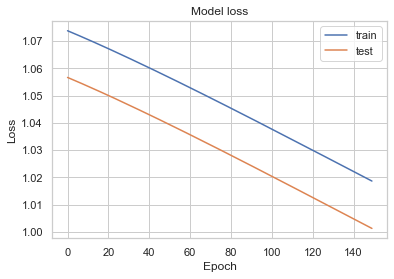

In [137]:
# plot loss
plt.plot(historyv2.history['loss'], label='train')
plt.plot(historyv2.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [138]:
test_x_predictions = autoencoder.predict(test_x)
mse = np.mean(np.power(test_x - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.describe()

99/99 [==============================] - 0s 944us/step


,Reconstruction_error,True_class
count,3148.000000,3148.000000
mean,2.281851,0.046061
std,10.100224,0.209651
min,0.181512,0.000000
25%,0.456039,0.000000
50%,0.685940,0.000000
75%,1.096937,0.000000
max,243.874784,1.000000


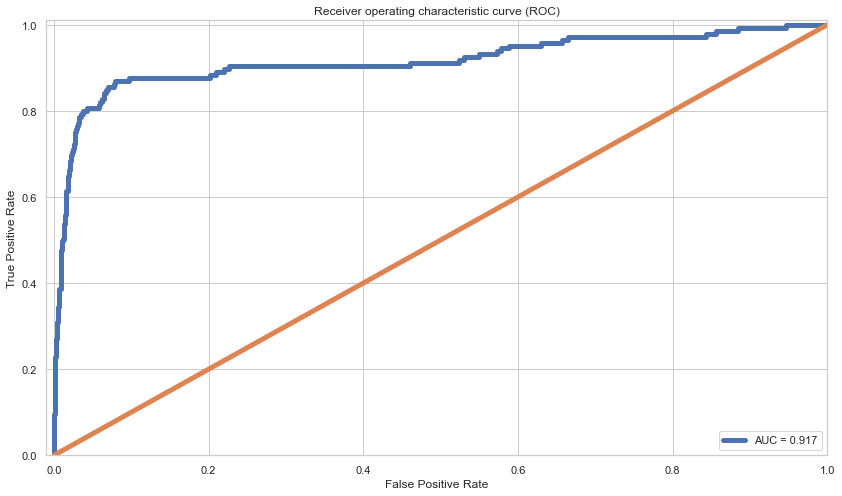

In [139]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

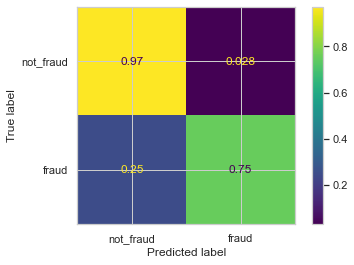

In [140]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > THRESOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [141]:
history = autoencoder.fit(xs_non_fraud[0:SAMPLE_SIZE], xs_non_fraud[0:SAMPLE_SIZE], 
                batch_size = BATCH_SIZE, epochs = EPOCHS, 
                shuffle = True, validation_split = SPLIT_RATIO);

Epoch 1/150
8/8 [==============================] - 0s 12ms/step - loss: 0.2901 - val_loss: 0.2943
Epoch 2/150
8/8 [==============================] - 0s 8ms/step - loss: 0.2889 - val_loss: 0.2931
Epoch 3/150
8/8 [==============================] - 0s 8ms/step - loss: 0.2877 - val_loss: 0.2919
Epoch 4/150
8/8 [==============================] - 0s 9ms/step - loss: 0.2865 - val_loss: 0.2907
Epoch 5/150
8/8 [==============================] - 0s 8ms/step - loss: 0.2853 - val_loss: 0.2895
Epoch 6/150
8/8 [==============================] - 0s 9ms/step - loss: 0.2841 - val_loss: 0.2883
Epoch 7/150
8/8 [==============================] - 0s 9ms/step - loss: 0.2829 - val_loss: 0.2871
Epoch 8/150
8/8 [==============================] - 0s 9ms/step - loss: 0.2818 - val_loss: 0.2859
Epoch 9/150
8/8 [==============================] - 0s 9ms/step - loss: 0.2806 - val_loss: 0.2848
Epoch 10/150
8/8 [==============================] - 0s 9ms/step - loss: 0.2794 - val_loss: 0.2836
Epoch 11/150
8/8 [==========

8/8 [==============================] - 0s 8ms/step - loss: 0.1997 - val_loss: 0.2035
Epoch 85/150
8/8 [==============================] - 0s 7ms/step - loss: 0.1986 - val_loss: 0.2023
Epoch 86/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1975 - val_loss: 0.2012
Epoch 87/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1964 - val_loss: 0.2001
Epoch 88/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1952 - val_loss: 0.1989
Epoch 89/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1941 - val_loss: 0.1978
Epoch 90/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1930 - val_loss: 0.1966
Epoch 91/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1918 - val_loss: 0.1955
Epoch 92/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1907 - val_loss: 0.1943
Epoch 93/150
8/8 [==============================] - 0s 8ms/step - loss: 0.1896 - val_loss: 0.1932
Epoch 94/150
8/8 [===============

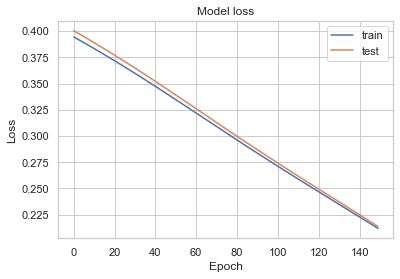

In [106]:
# plot loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [154]:
test_x_predictions = autoencoder.predict(x_scale)
mse = np.mean(np.power(x_scale - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y})
error_df.describe()

8901/8901 [==============================] - 7s 832us/step


,Reconstruction_error,True_class
count,284807.000000,284807.000000
mean,0.138773,0.001727
std,0.012429,0.041527
min,0.080813,0.000000
25%,0.128853,0.000000
50%,0.137602,0.000000
75%,0.148501,0.000000
max,0.372739,1.000000


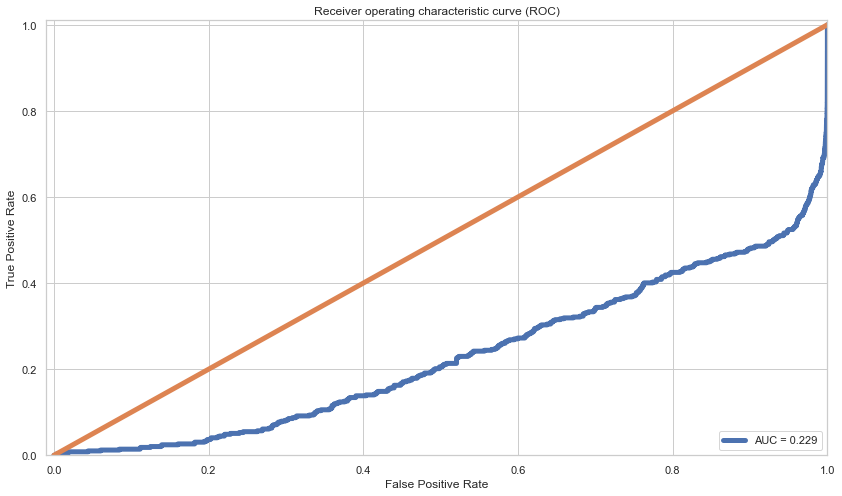

In [155]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.figure(figsize=(14, 8))
plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

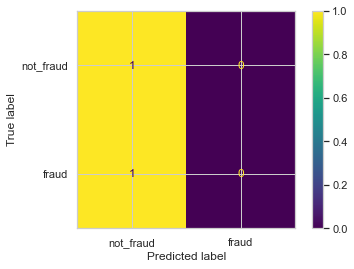

In [156]:
# As with autoencoders, it is the assumption that fraud or anomalies will suffer 
# from a detectably high reconstruction error, predicting class as 1 (Fraud)
# if reconstruction error is greater than threshold
pred_y = [1 if e > THRESOLD_FIXED else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y,normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [157]:
pred_y

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


## Obtain the Latent Representations 

Now, the model is trained. We are intereseted in obtaining **latent representation of the input** learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists. 

In [26]:
hidden_scaled_representation = Sequential()
hidden_scaled_representation.add(autoencoder.layers[0])
hidden_scaled_representation.add(autoencoder.layers[1])
hidden_scaled_representation.add(autoencoder.layers[2])
hidden_scaled_representation.add(autoencoder.layers[3])

Generate the hidden representations of two classes : non-fraud and fraud by predicting the raw inputs using the above model.

### Training the AE on non-normalised data

In [27]:
x_unscale = x.values
xu_non_fraud, xu_fraud = x_unscale[y == 0], x_unscale[y == 1] # xu - unscaled x

autoencoder.fit(xu_non_fraud[0:SAMPLE_SIZE], xu_non_fraud[0:SAMPLE_SIZE], 
                batch_size = BATCH_SIZE, epochs = EPOCHS, 
                shuffle = True, validation_split = SPLIT_RATIO);

hidden_unscaled_representation = Sequential()
hidden_unscaled_representation.add(autoencoder.layers[0])
hidden_unscaled_representation.add(autoencoder.layers[1])
hidden_unscaled_representation.add(autoencoder.layers[2])
hidden_unscaled_representation.add(autoencoder.layers[3])

Epoch 1/25
8/8 [==============================] - 0s 14ms/step - loss: 1388.1591 - val_loss: 738.9348
Epoch 2/25
8/8 [==============================] - 0s 10ms/step - loss: 1387.6306 - val_loss: 738.6345
Epoch 3/25
8/8 [==============================] - 0s 9ms/step - loss: 1387.1285 - val_loss: 738.3181
Epoch 4/25
8/8 [==============================] - 0s 9ms/step - loss: 1386.5551 - val_loss: 737.9361
Epoch 5/25
8/8 [==============================] - 0s 9ms/step - loss: 1385.8503 - val_loss: 737.4616
Epoch 6/25
8/8 [==============================] - 0s 11ms/step - loss: 1384.9606 - val_loss: 736.9448
Epoch 7/25
8/8 [==============================] - 0s 10ms/step - loss: 1384.1062 - val_loss: 736.5029
Epoch 8/25
8/8 [==============================] - 0s 10ms/step - loss: 1383.3790 - val_loss: 736.1231
Epoch 9/25
8/8 [==============================] - 0s 10ms/step - loss: 1382.7500 - val_loss: 735.7943
Epoch 10/25
8/8 [==============================] - 0s 11ms/step - loss: 1382.1899 - v

In [28]:
non_fraud_hid_scaled_rep = hidden_scaled_representation.predict(xs_non_fraud[:SAMPLE_SIZE])
fraud_hid_scaled_rep = hidden_scaled_representation.predict(xs_fraud)

non_fraud_hid_unscaled_rep = hidden_unscaled_representation.predict(xu_non_fraud[:SAMPLE_SIZE])
fraud_hid_unscaled_rep = hidden_unscaled_representation.predict(xu_fraud)

16/16 [==============================] - 0s 934us/step


## 5. Visualize the latent representations : Fraud Vs Non Fraud

Now we will create a training dataset using the latent representations obtained and let's visualize the nature of fraud vs non-fraud cases. 

In [29]:
rep_xs = np.append(non_fraud_hid_scaled_rep, fraud_hid_scaled_rep, axis = 0)
y_n = np.zeros(non_fraud_hid_scaled_rep.shape[0])
y_f = np.ones(fraud_hid_scaled_rep.shape[0])
rep_ys = np.append(y_n, y_f)
tsne_plot(rep_xs, rep_ys, "latent_representation_scaled.png")

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TypeError: must be real number, not str

<Figure size 864x576 with 1 Axes>

In [30]:
rep_xu = np.append(non_fraud_hid_unscaled_rep, fraud_hid_unscaled_rep, axis = 0)
y_n = np.zeros(non_fraud_hid_unscaled_rep.shape[0])
y_f = np.ones(fraud_hid_unscaled_rep.shape[0])
rep_yu = np.append(y_n, y_f)
tsne_plot(rep_xu, rep_yu, "latent_representation_unscaled.png")

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


TypeError: must be real number, not str

<Figure size 864x576 with 1 Axes>

What a perfect graph, we can observe that now fraud and non-fraud transactions are pretty visibile and are linearly separable. Now we dont need any complex model to classify this, even the simpler models can be used to predict.  Here is the before and after view of Fraud and Non Fraud transactions.

In [31]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original_10000.png'></td><td>
             <img src='latent_representation_unscaled.png'></td><td>
             <img src='latent_representation_scaled.png'></td></tr></table>"""))

## Simple Linear Classifier

In [32]:
train_xs, val_xs, train_ys, val_ys = train_test_split(rep_xs, rep_ys, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_xs, train_ys)
pred_ys = clf.predict(val_xs)

print ("")
print ("Classification Report: ")
print (classification_report(val_ys, pred_ys))

print ("")
print ("Accuracy Score: ", accuracy_score(val_ys, pred_ys))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2508
         1.0       1.00      0.78      0.88       115

    accuracy                           0.99      2623
   macro avg       1.00      0.89      0.94      2623
weighted avg       0.99      0.99      0.99      2623


Accuracy Score:  0.9904689287075867


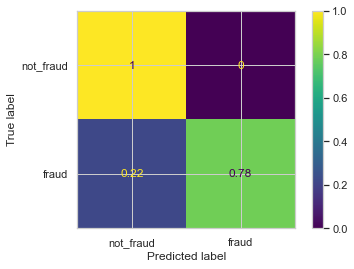

In [48]:
cm = confusion_matrix(val_ys, pred_ys, labels=clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [33]:
train_xu, val_xu, train_yu, val_yu = train_test_split(rep_xu, rep_yu, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_xu, train_yu)
pred_yu = clf.predict(val_xu)

print ("")
print ("Classification Report: ")
print (classification_report(val_yu, pred_yu))

print ("")
print ("Accuracy Score: ", accuracy_score(val_yu, pred_yu))


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2508
         1.0       1.00      0.94      0.97       115

    accuracy                           1.00      2623
   macro avg       1.00      0.97      0.98      2623
weighted avg       1.00      1.00      1.00      2623


Accuracy Score:  0.9973313000381243


C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


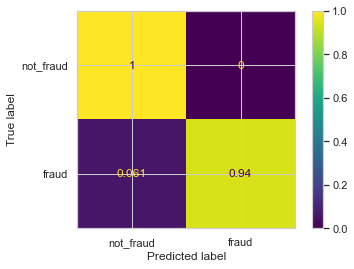

In [50]:
cm = confusion_matrix(val_yu,pred_yu , labels=clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

## Non-Linear Classifier

In [52]:
svc_clf = SVC()
svc_clf.fit(train_xs, train_ys)
svcs_predictions = svc_clf.predict(val_xs)
print ("")
print ("Classification Report: ")
print (classification_report(val_ys, svcs_predictions))

print ("")
print ("Accuracy Score: ", accuracy_score(val_ys, svcs_predictions))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2508
         1.0       1.00      0.87      0.93       115

    accuracy                           0.99      2623
   macro avg       1.00      0.93      0.96      2623
weighted avg       0.99      0.99      0.99      2623


Accuracy Score:  0.994281357224552


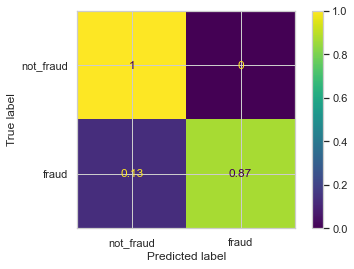

In [57]:
cm = confusion_matrix(val_ys,svcs_predictions , labels=svc_clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

In [58]:
svc_clf = SVC()
svc_clf.fit(train_xu, train_yu)
svcu_predictions = svc_clf.predict(val_xu)
print ("")
print ("Classification Report: ")
print (classification_report(val_yu, svcu_predictions))

print ("")
print ("Accuracy Score: ", accuracy_score(val_yu, svcu_predictions))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      2508
         1.0       1.00      0.77      0.87       115

    accuracy                           0.99      2623
   macro avg       0.99      0.88      0.93      2623
weighted avg       0.99      0.99      0.99      2623


Accuracy Score:  0.9897064430041936


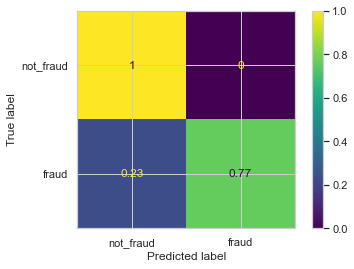

In [59]:
cm = confusion_matrix(val_yu,svcu_predictions , labels=svc_clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

## XgBoost

In [62]:
model = xgb.XGBClassifier(
    n_estimators=2000,
    max_depth = 10,
    early_stopping_rounds=10,
    learning_rate=0.1,
    tree_method="exact",
    booster='gbtree',
    importance_type='gain',
    # scale up the weight of positive samples
    use_label_encoder=False,
    eval_metric=["error","logloss"]
)

#xgbc = xgb.XGBClassifier(n_jobs=4, max_depth=10, min_samples_leaf=0.001, 
                         #learning_rate=0.1, n_estimators=100, eval_metric="auc")
#xgbc.fit(Xtr, np.ravel(Ytr))
#submission["isFraud"] = xgbc.predict_proba(Xte)[:, 1]

In [67]:
eval_set=[(train_xs,train_ys)]
model.fit(train_xs, train_ys,eval_set=eval_set,verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['error', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [69]:
xgb_predictions = model.predict(val_xs)
print ("")
print ("Classification Report: ")
print (classification_report(val_ys, xgb_predictions))

print ("")
print ("Accuracy Score: ", accuracy_score(val_ys, xgb_predictions))


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2508
         1.0       0.98      0.98      0.98       115

    accuracy                           1.00      2623
   macro avg       0.99      0.99      0.99      2623
weighted avg       1.00      1.00      1.00      2623


Accuracy Score:  0.9984750285932139


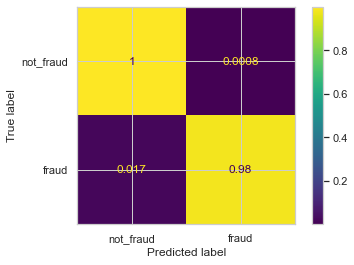

In [71]:
cm = confusion_matrix(val_ys,xgb_predictions , labels=model.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

## Making a simple Neural Network to classify on the lastent space

In [79]:
class Metric_s(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self,epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(val_xs))).round()
        val_targ = val_ys
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return


metric_s = Metric_s()

In [80]:
# Build the model
latent_classifier_model = Sequential()
latent_classifier_model.add(Dense(10, input_dim=25, activation='relu'))
latent_classifier_model.add(Dense(10, activation='relu'))
latent_classifier_model.add(Dense(1, activation='sigmoid'))
latent_classifier_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
latent_classifier_model.fit(train_xs, train_ys, epochs=NN_EPOCHS, batch_size=NN_BATCH_SIZE, callbacks=[metric_s])

# Evaluate the model
model_pred = latent_classifier_model.predict(val_xs)
# print ("")
# print ("Classification Report: ")

# print ("")
# print ("Accuracy Score: ", accuracy_score(val_ys, model_pred))

Epoch 1/50
82/82 [==============================] - 0s 850us/steposs: 0.2740 - accuracy: 0.
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
394/394 [==============================] - 1s 2ms/step - loss: 0.2681 - accuracy: 0.9163
Epoch 2/50
111/394 [=======>......................] - ETA: 0s - loss: 0.1724 - accuracy: 0.9495

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/82 [==============================] - 0s 803us/steposs: 0.1571 - accuracy: 0.
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
394/394 [==============================] - 1s 2ms/step - loss: 0.1574 - accuracy: 0.9521
Epoch 3/50
173/394 [============>.................] - ETA: 0s - loss: 0.1294 - accuracy: 0.9532

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/82 [==============================] - 0s 796us/steposs: 0.1133 - accuracy: 0.
 — val_f1: 0.5161290322580645 — val_precision: 1.0 — val_recall: 0.34782608695652173
394/394 [==============================] - 1s 1ms/step - loss: 0.1132 - accuracy: 0.9590
Epoch 4/50
82/82 [==============================] - 0s 779us/steposs: 0.0694 - accuracy: 0.
 — val_f1: 0.7150837988826816 — val_precision: 1.0 — val_recall: 0.5565217391304348
394/394 [==============================] - 1s 1ms/step - loss: 0.0685 - accuracy: 0.9784
Epoch 5/50
82/82 [==============================] - 0s 773us/steposs: 0.0474 - accuracy: 0.
 — val_f1: 0.8383838383838385 — val_precision: 1.0 — val_recall: 0.7217391304347827
394/394 [==============================] - 1s 1ms/step - loss: 0.0462 - accuracy: 0.9864
Epoch 6/50
82/82 [==============================] - 0s 801us/steposs: 0.0355 - accuracy: 0.
 — val_f1: 0.888888888888889 — val_precision: 1.0 — val_recall: 0.8
394/394 [==============================] - 1s 1ms/step 

Epoch 33/50
82/82 [==============================] - 0s 808us/steposs: 0.0153 - accuracy: 0.
 — val_f1: 0.9446808510638298 — val_precision: 0.925 — val_recall: 0.9652173913043478
394/394 [==============================] - 1s 1ms/step - loss: 0.0161 - accuracy: 0.9961
Epoch 34/50
82/82 [==============================] - 0s 826us/steposs: 0.0169 - accuracy: 0.
 — val_f1: 0.9473684210526316 — val_precision: 0.9557522123893806 — val_recall: 0.9391304347826087
394/394 [==============================] - 1s 1ms/step - loss: 0.0161 - accuracy: 0.9963
Epoch 35/50
82/82 [==============================] - 0s 774us/steposs: 0.0166 - accuracy: 0.
 — val_f1: 0.9437229437229439 — val_precision: 0.9396551724137931 — val_recall: 0.9478260869565217
394/394 [==============================] - 1s 1ms/step - loss: 0.0159 - accuracy: 0.9963
Epoch 36/50
82/82 [==============================] - 0s 755us/steposs: 0.0159 - accuracy: 0.
 — val_f1: 0.9473684210526316 — val_precision: 0.9557522123893806 — val_recal

In [85]:
model_pred

array([[1.9799175e-03],
       [9.9999678e-01],
       [2.8316462e-03],
       ...,
       [1.4573052e-03],
       [6.7263516e-04],
       [4.7986137e-04]], dtype=float32)

In [77]:
cm = confusion_matrix(val_ys,model_pred ,normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not_fraud", "fraud"])
disp.plot()
plt.show()

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### Neural network on unscaled data

In [86]:
class Metric_u(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self,epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(val_xu))).round()
        val_targ = val_yu
        _val_f1 = f1_score(val_targ, val_predict)
        _val_recall = recall_score(val_targ, val_predict)
        _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f" — val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return


metric_u = Metric_u()

In [87]:
# Build the model
latent_classifier_model = Sequential()
latent_classifier_model.add(Dense(10, input_dim=25, activation='relu'))
latent_classifier_model.add(Dense(10, activation='relu'))
latent_classifier_model.add(Dense(1, activation='sigmoid'))
latent_classifier_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
latent_classifier_model.fit(train_xu, train_yu, epochs=NN_EPOCHS, batch_size=NN_BATCH_SIZE, callbacks=[metric_u])

# Evaluate the model
model_pred = latent_classifier_model.predict(val_xu)

Epoch 1/50
82/82 [==============================] - 0s 813us/steposs: 0.2901 - accuracy: 0.
 — val_f1: 0.0 — val_precision: 0.0 — val_recall: 0.0
394/394 [==============================] - 1s 2ms/step - loss: 0.2813 - accuracy: 0.9521
Epoch 2/50
123/394 [========>.....................] - ETA: 0s - loss: 0.1178 - accuracy: 0.9512

C:\Users\jerom\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


82/82 [==============================] - 0s 782us/steposs: 0.0937 - accuracy: 0.
 — val_f1: 0.8 — val_precision: 0.975 — val_recall: 0.6782608695652174
394/394 [==============================] - 1s 2ms/step - loss: 0.0912 - accuracy: 0.9645
Epoch 3/50
82/82 [==============================] - 0s 809us/steposs: 0.0429 - accuracy: 0.
 — val_f1: 0.9162995594713658 — val_precision: 0.9285714285714286 — val_recall: 0.9043478260869565
394/394 [==============================] - 1s 1ms/step - loss: 0.0432 - accuracy: 0.9863
Epoch 4/50
82/82 [==============================] - 0s 794us/steposs: 0.0333 - accuracy: 0.
 — val_f1: 0.9107981220657276 — val_precision: 0.9897959183673469 — val_recall: 0.8434782608695652
394/394 [==============================] - 1s 1ms/step - loss: 0.0329 - accuracy: 0.9903
Epoch 5/50
82/82 [==============================] - 0s 770us/steposs: 0.0262 - accuracy: 0.
 — val_f1: 0.8942307692307693 — val_precision: 1.0 — val_recall: 0.808695652173913
394/394 [===============

Epoch 32/50
82/82 [==============================] - 0s 847us/steposs: 0.0107 - accuracy: 0.
 — val_f1: 0.9519650655021834 — val_precision: 0.956140350877193 — val_recall: 0.9478260869565217
394/394 [==============================] - 1s 2ms/step - loss: 0.0108 - accuracy: 0.9966
Epoch 33/50
82/82 [==============================] - 0s 830us/steposs: 0.0107 - accuracy: 0.
 — val_f1: 0.9363636363636364 — val_precision: 0.9809523809523809 — val_recall: 0.8956521739130435
394/394 [==============================] - 1s 1ms/step - loss: 0.0103 - accuracy: 0.9971
Epoch 34/50
82/82 [==============================] - 0s 783us/steposs: 0.0101 - accuracy: 0.
 — val_f1: 0.9515418502202643 — val_precision: 0.9642857142857143 — val_recall: 0.9391304347826087
394/394 [==============================] - 1s 1ms/step - loss: 0.0108 - accuracy: 0.9964
Epoch 35/50
82/82 [==============================] - 0s 860us/steposs: 0.0112 - accuracy: 0.
 — val_f1: 0.9557522123893805 — val_precision: 0.972972972972973 